purpose: because the humanbase networks are flipping enormous, you can't do network propagation all in one go, because you have to store too much information in memory. to get around that, we need to construct the adjacency matrix piecemeal. this is to test if that method works properly using PCNet2.0, because you can compare the output of normal network propagation and piecemeal using this size interactome.

In [4]:
import os
import pandas as pd
import ndex2
import networkx as nx
from netcoloc import netprop_zscore
from netcoloc import netprop
from netcoloc import network_colocalization
import sys
import pickle
import random

import gzip
import numpy as np
import scipy.sparse as sp
from collections import defaultdict

#os.chdir('/tscc/projects/ps-palmer/brittany/rare_common_alcohol/rare_common_alcohol_comparison/notebooks/')
#from rca_functions import *
os.chdir('/tscc/projects/ps-palmer/brittany/SUD_cross_species/scripts')
from network_functions import *
from network_validation_functions import *
from plotting_functions import *
os.chdir('/tscc/projects/ps-palmer/brittany/SUD_cross_species/')

In [5]:
random_seed=random.seed(211)

In [7]:
UUIDs.keys()

dict_keys(['PCNet2.0', 'PCNet2.1', 'PCNet2.2', 'signor_rat', 'signor_human', 'signor_mouse'])

In [8]:
os.chdir('/tscc/projects/ps-palmer/brittany/SUD_cross_species/')

In [22]:
#create a file called environ_ndex_meta.py where you save variables 'ndex_user' and 'ndex_password'
#otherwise will prompt you to define those within the notebooks
if os.path.isfile('../environ_ndex_meta.py'):
    print ('NDEx credentials imported from meta file')
    sys.path.insert(1, '../')
    from environ_ndex_meta import *
    sys.path.pop(1)
else:
    # Prompt the user for a username
    ndex_user = input("Enter your NDEx username: ")
    # Prompt the user for a password
    ndex_password = input("Enter your NDEx password: ")

NDEx credentials imported from meta file


# import interactome from ndex

In [43]:
interactome_name='PCNet2.0'
print(f'importing {interactome_name} from ndex')
graph=import_interactome(UUIDs=UUIDs,interactome_name=interactome_name)

importing PCNet2.0 from ndex
PCNet2.0
Name: PCNet 2.0
Nodes: 19267
Edges: 3852119
Node Attributes: 19267
Edge Attributes: 19260595

number of nodes:
19267

number of edges:
3852119


In [188]:
edgesc=list(graph.edges())
nodesc=list(graph.nodes())

In [121]:
degreec=dict(graph.degree())

# write standard output to file

In [1]:
outdir='tissue_networks/intermediate/'

In [22]:
#write to file edges to use for piecewise calculation
nx.write_edgelist(graph, f'{outdir}edge_list_{interactome_name}.txt', comments='#', delimiter=' ', data=True, encoding='utf-8')

In [24]:
#write nodes to file
with open(f'{outdir}node_list_{interactome_name}_correct.txt', 'w') as f:
    for node in nodesc:
        f.write(f"{node}\n")

In [89]:
# pre calculate the matricies used for network propagation
print('\ncalculating w_prime')
w_prime = netprop.get_normalized_adjacency_matrix(graph, conserve_heat=True)
print('\ncalculating w_double_prime')
w_double_prime = netprop.get_individual_heats_matrix(w_prime, .5)


calculating w_prime

calculating w_double_prime


In [26]:
#for checking the method from format_tissue_specific_network
import scipy.sparse as sp
wpc=sp.csr_matrix(w_prime)
outdir='tissue_networks/intermediate/'
sp.save_npz(f'{outdir}normalized_adjacency_{interactome_name}_correct.npz', wpc)

In [105]:
np.save(f'{outdir}w_double_prime_{interactome_name}_correct',w_double_prime)

In [55]:
d=pd.DataFrame(graph.degree())
d.index=d[0]
d[1].to_csv(f'{outdir}degree_{interactome_name}_correct.csv',header=None)

# calculate the adjacency matrix using the edge list

## functions

In [410]:
def normalize_adj_matrix_by_chunk(file_path, chunk_size=100000):
    node_set = set()
    edges = []
    node_index = {}
    
    # First pass: determine unique nodes and create an index
    with gzip.open(file_path, 'rt') as file:
        while True:
            lines = [file.readline() for _ in range(chunk_size)]
            if not lines or lines[0] == '':
                break  # Stop at EOF
            
            for line in lines:
                parts = line.strip().split()
                if len(parts) < 2:
                    continue  # Skip malformed lines
                
                node1, node2 = (parts[0]), (parts[1])
                
                node_set.add(node1)
                node_set.add(node2)
                edges.append((node1, node2))
                edges.append((node2, node1))  # Ensure symmetry
    
    # Create node index mapping
    node_list = sorted(node_set)  # Ensure consistent order- MUST REPLACE WHEN FIXED
    node_index = {node: idx for idx, node in enumerate(node_list)}
    
    # Second pass: construct sparse adjacency matrix
    row_idx, col_idx = [], []
    degree = defaultdict(int)
    
    with gzip.open(file_path, 'rt') as file:
        while True:
            lines = [file.readline() for _ in range(chunk_size)]
            if not lines or lines[0] == '':
                break  # Stop at EOF
            
            for line in lines:
                parts = line.strip().split()
                if len(parts) < 2:
                    continue  # Skip malformed lines
                
                node1, node2 = (parts[0]), (parts[1])
    
                i, j = node_index[node1], node_index[node2]
                
                # Store indices (all weights are 1)
                row_idx.append(i)
                col_idx.append(j)
                row_idx.append(j)
                col_idx.append(i)  # Ensure symmetric adjacency matrix
                
                # Update node degree
                degree[node1] += 1
                degree[node2] += 1

    n = len(node_list)
    adj_matrix = sp.csr_matrix((np.ones(len(row_idx)), (row_idx, col_idx)), shape=(n, n))

    #normalize adjacency matrix
    row_idx, col_idx = adj_matrix.nonzero()
    weight_vals = adj_matrix.data.copy()  # Copy original weights (all 1s)
    
    if conserve_heat:
        for k in range(len(weight_vals)):
            i, j = row_idx[k], col_idx[k]
            weight_vals[k] = 1/degree[node_list[i]]  # Normalize by the degree of the destination node
    
    else:
        for k in range(len(weight_vals)):
            i, j = row_idx[k], col_idx[k]
            weight_vals[k] = 1/np.sqrt(degree[node_list[i]] * degree[node_list[j]])
    
    x=sp.csr_matrix((weight_vals, (row_idx, col_idx)), shape=adj_matrix.shape)
    return x, node_index, dict(degree), node_list

In [260]:
import gzip
import numpy as np
import scipy.sparse as sp
from collections import defaultdict

def process_network_in_chunks(file_path, nodes, chunk_size=100000):
    """
    Reads a large network from a gzipped file in chunks and creates a sparse adjacency matrix.
    
    :param file_path: Path to the gzipped network file.
    :param chunk_size: Number of lines to read per chunk.
    :return: Sparse adjacency matrix in CSR format.
    """
    node_set = set()
    edges = []
    weights = []
    node_index = {}

    # First pass: determine unique nodes and create an index
    with gzip.open(file_path, 'rt') as file:
        while True:
            lines = [file.readline() for _ in range(chunk_size)]
            if not lines or lines[0] == '':
                break  # Stop at EOF
            
            for line in lines:
                parts = line.strip().split()
                if len(parts) < 2:
                    continue  # Skip malformed lines
                
                node1, node2 = (parts[0]), (parts[1])
                weight = 1
                
                node_set.add(node1)
                node_set.add(node2)
                edges.append((node1, node2))
                weights.append(weight)

    # Create node index mapping
    #node_list = sorted(node_set)
    nodes_list=nodes
    print(nodes)
    node_index = {node: idx for idx, node in enumerate(nodes)}
    # Second pass: construct sparse adjacency matrix
    row_idx, col_idx, weight_vals = [], [], []
    degree = defaultdict(int)

    with gzip.open(file_path, 'rt') as file:
        while True:
            lines = [file.readline() for _ in range(chunk_size)]
            if not lines or lines[0] == '':
                break  # Stop at EOF
            
            for line in lines:
                parts = line.strip().split()
                if len(parts) < 2:
                    continue  # Skip malformed lines
                
                node1, node2 = (parts[0]), (parts[1])
                weight = 1

                i, j = node_index[node1], node_index[node2]
                
                # Store indices and weights
                row_idx.append(i)
                col_idx.append(j)
                weight_vals.append(weight)
                
                # Update node degree
                degree[node1] += 1
                degree[node2] += 1

    # Create sparse adjacency matrix
    n = len(node_list)
    adj_matrix = sp.csr_matrix((weight_vals, (row_idx, col_idx)), shape=(n, n))

    return adj_matrix, node_index, degree

def normalize_adjacency_matrix(adj_matrix, nodes, node_index, degree, conserve_heat=True):
    """
    Normalizes the sparse adjacency matrix for network propagation.
    
    :param adj_matrix: Input sparse adjacency matrix.
    :param node_index: Dictionary mapping node IDs to matrix indices.
    :param degree: Dictionary of node degrees.
    :param conserve_heat: If True, use asymmetric normalization.
    :return: Normalized sparse adjacency matrix.
    """
    row_idx, col_idx = adj_matrix.nonzero()
    weight_vals = adj_matrix.data.copy()

    if conserve_heat:
        for k in range(len(weight_vals)):
            i, j = row_idx[k], col_idx[k]
            weight_vals[k] /= degree[node_list[i]]
    
    else:
        for k in range(len(weight_vals)):
            i, j = row_idx[k], col_idx[k]
            weight_vals[k] /= np.sqrt(degree[node_list[i]] * degree[node_list[j]])

    return sp.csr_matrix((weight_vals, (row_idx, col_idx)), shape=adj_matrix.shape)


## calculate and export

In [241]:
file_path=f'tissue_networks/intermediate/edge_list_PCNet2.0.txt.gz'

In [411]:
wp, node_index, degree, node_list= normalize_adj_matrix_by_chunk(file_path)

In [128]:
pd.DataFrame.from_dict(degree,orient='index').to_csv(f'{outdir}degree_{interactome_name}.csv',header=None)

In [3]:
tissue='PCNet2.0'

In [42]:
# write the node list and adjacency matrix to file
#outdir='tissue_networks/intermediate/'

# Save adjacency matrix as a sparse file
sp.save_npz(f'{outdir}normalized_adjacency_{interactome_name}.npz', wp)

# Save the node list in the same order as adjacency matrix
with open(f'{outdir}node_list_{interactome_name}.txt', 'w') as f:
    for node in node_list:
        f.write(f"{node}\n")

In [417]:
# calculate w_double_prime and write it to file
wdp = netprop.get_individual_heats_matrix(wp, .5)
np.save(f'{outdir}w_double_prime_{interactome_name}',wdp)

# compare the output from both methods

In [14]:
wdp=np.loadtxt(f'{outdir}w_double_prime_{tissue}.csv',delimiter=',')
wdpc=np.loadtxt(f'{outdir}w_double_prime_{tissue}_correct.csv')

In [213]:
wdp=np.array(wdp)

In [218]:
set([row[nodesc.index('TGFBR1')] for row in wdpc])==set([row[nodes.index('TGFBR1')] for row in wdp])

False

In [231]:
norm_adj_matrix.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [24]:
wp=sp.load_npz(f'{outdir}normalized_adjacency_{tissue}.npz')
wpc=sp.load_npz(f'{outdir}normalized_adjacency_{tissue}_correct.npz')

In [21]:
with open(f'{outdir}node_list_PCNet2.0.txt', 'r') as file:
    lines = file.readlines()
# Remove newline characters from each line
nodes=[line.strip() for line in lines]

with open(f'{outdir}node_list_PCNet2.0_correct.txt', 'r') as file:
    lines = file.readlines()
# Remove newline characters from each line
nodesc=[line.strip() for line in lines]

In [22]:
print(nodes==nodesc) #nodes not listed in the same order
print(set(nodes)==set(nodesc)) #but they are the same list of nodes

False

In [106]:
wdpc=np.load(f'{outdir}w_double_prime_{tissue}_correct.npy')

In [32]:
wdp==wdpc

array([False, False, False, ..., False, False, False])

In [34]:
wdp

array([5.00000000e-01, 0.00000000e+00, 4.45544301e-04, ...,
       9.48661104e-06, 0.00000000e+00, 5.00000000e-01])

In [154]:
w_double_prime = netprop.get_individual_heats_matrix(wp, .5)

the nodes are in different orders, and the values in the arrays are in different orders. HOWEVER, the order doesn't really matter as long as they perform the same in network propagation soooooo..... lets test that.

# test network propagation

In [42]:
save_file=False #don't want to overwrite propagation scores using the correct PCNet2.0

In [ ]:
# import genes- shouldn't matter which list of nodes is used since they're the same set

In [38]:
seed_dict=import_seed_dict(mag_dir,file_dict,bonf_dict,gene_col_dict,nodesc)
seed_dict.keys()

dict_keys(['loco_bonf', 'loco_top500', 'loco_FDR', 'loco_gsem_bonf', 'loco_gsem_top500', 'loco_gsem_FDR', 'ext_bonf', 'ext_top500', 'ext_FDR', 'ext_st22', 'loco_mega_fus_naac_bonf', 'loco_mega_fus_naac_top500', 'loco_mega_fus_naac_FDR', 'ext_fus_naac_bonf', 'ext_fus_naac_top500', 'ext_fus_naac_FDR'])

In [40]:
#dictionary of human control traits
ctrl_dict={}
ctrl_traits=['facial_hair', 'age_smkinit', 'antisoc', 'friend_sat', 'hr', 'infant_bw', 'LDL', 'maternal_smok', 'townsend', 'age_menarche', 'neurot','addict-rf']
for t in ctrl_traits:
    ctrl_dict[t]=pd.read_csv('gwas_ctrl_hm/magma/seed_genes/'+t+'_annot.tsv',sep='\t')
for t in ctrl_traits:
    seed_dict[t+'_FDR']=(set(ctrl_dict[t][ctrl_dict[t]['Q']<0.05]['GENE']))
    seed_dict[t+'_bonf']=(set(ctrl_dict[t][ctrl_dict[t]['P']<0.05/len(ctrl_dict[t])]['GENE']))
    seed_dict[t+'_top500']=set(ctrl_dict[t][(ctrl_dict[t]['GENE'].isin(nodesc))].nsmallest(500,'P')['GENE'])

In [ ]:
NPSc, Fnew_score, Fnew_rand_score = netprop_zscore.calculate_heat_zscores(
    w_double_prime,  
    list(graph.nodes()),
    dict(graph.degree), 
    seed_genes, num_reps=1000,
    minimum_bin_size=100,
    random_seed=random_seed)

In [119]:
dict(graph.degree)

{'TGFBR1': 792,
 'TGFBR2': 578,
 'SMAD3': 882,
 'TGFB1': 1172,
 'SMAD2': 1624,
 'TGFB3': 549,
 'SMAD4': 1110,
 'TGFB2': 664,
 'ACVR1C': 89,
 'SMAD7': 315,
 'ACVR1': 477,
 'ACVRL1': 185,
 'ACVR1B': 345,
 'BMPR1B': 247,
 'BMPR1A': 589,
 'ACVR2B': 274,
 'SMAD6': 342,
 'ACVR2A': 297,
 'STRAP': 2013,
 'SMAD1': 416,
 'SMAD5': 658,
 'BAMBI': 96,
 'FKBP1A': 1224,
 'BMPR2': 357,
 'SMURF2': 702,
 'ENG': 565,
 'CD4': 1011,
 'SMURF1': 671,
 'TGFBR3': 236,
 'ZFYVE9': 223,
 'MAP3K7': 1628,
 'USP15': 1235,
 'CGN': 293,
 'PMEPA1': 224,
 'TRAF6': 1008,
 'FBN1': 565,
 'ACTA2': 1744,
 'PARD3': 622,
 'MTMR4': 555,
 'CAV1': 1716,
 'SNAI1': 413,
 'TMEM119': 115,
 'BMP2': 514,
 'SERPINE1': 790,
 'PDGFA': 361,
 'AMHR2': 235,
 'SKI': 201,
 'SNX6': 809,
 'ARMS2': 76,
 'NRP1': 453,
 'DAB2': 699,
 'PARD6A': 191,
 'P2RY12': 331,
 'INHBA': 387,
 'PRKCZ': 784,
 'COL3A1': 653,
 'USP4': 627,
 'SLC16A8': 202,
 'COL1A1': 903,
 'ALK': 347,
 'CD44': 1475,
 'IGF1R': 682,
 'SLC2A10': 189,
 'BMP7': 604,
 'TNFRSF10A': 223,
 '

In [120]:
degreec

DegreeView({'TGFBR1': 792, 'TGFBR2': 578, 'SMAD3': 882, 'TGFB1': 1172, 'SMAD2': 1624, 'TGFB3': 549, 'SMAD4': 1110, 'TGFB2': 664, 'ACVR1C': 89, 'SMAD7': 315, 'ACVR1': 477, 'ACVRL1': 185, 'ACVR1B': 345, 'BMPR1B': 247, 'BMPR1A': 589, 'ACVR2B': 274, 'SMAD6': 342, 'ACVR2A': 297, 'STRAP': 2013, 'SMAD1': 416, 'SMAD5': 658, 'BAMBI': 96, 'FKBP1A': 1224, 'BMPR2': 357, 'SMURF2': 702, 'ENG': 565, 'CD4': 1011, 'SMURF1': 671, 'TGFBR3': 236, 'ZFYVE9': 223, 'MAP3K7': 1628, 'USP15': 1235, 'CGN': 293, 'PMEPA1': 224, 'TRAF6': 1008, 'FBN1': 565, 'ACTA2': 1744, 'PARD3': 622, 'MTMR4': 555, 'CAV1': 1716, 'SNAI1': 413, 'TMEM119': 115, 'BMP2': 514, 'SERPINE1': 790, 'PDGFA': 361, 'AMHR2': 235, 'SKI': 201, 'SNX6': 809, 'ARMS2': 76, 'NRP1': 453, 'DAB2': 699, 'PARD6A': 191, 'P2RY12': 331, 'INHBA': 387, 'PRKCZ': 784, 'COL3A1': 653, 'USP4': 627, 'SLC16A8': 202, 'COL1A1': 903, 'ALK': 347, 'CD44': 1475, 'IGF1R': 682, 'SLC2A10': 189, 'BMP7': 604, 'TNFRSF10A': 223, 'LRG1': 175, 'MYT1L': 175, 'ID1': 281, 'FILIP1L': 71, '

In [179]:
k='loco_gsem_FDR'
print(len(seed_dict[k]))
seed_genes = list(seed_dict[k].intersection(nodesc))

NPS_c, Fnew_score_c, Fnew_rand_score_c = netprop_zscore.calculate_heat_zscores(
    wdpc,  
    nodesc,
    degreec, 
    seed_genes, num_reps=1000,
    minimum_bin_size=100,
    random_seed=random_seed)
print(NPS_c.head())

458


  0%|          | 0/1000 [00:00<?, ?it/s]

TGFBR1    2.225128
TGFBR2    1.543766
SMAD3    -0.775354
TGFB1    -0.094090
SMAD2     2.396493
dtype: float64


In [421]:
k='loco_gsem_FDR'
print(len(seed_dict[k]))
seed_genes = list(seed_dict[k].intersection(nodesc))

NPS, Fnew_score, Fnew_rand_score = netprop_zscore.calculate_heat_zscores(
    np.asarray(wdp),  
    nodes,
    degree, 
    seed_genes, num_reps=1000,
    minimum_bin_size=100,
    random_seed=random_seed)
print(NPS.head())

458


  0%|          | 0/1000 [00:00<?, ?it/s]

A1BG       2.682223
A1CF      -0.653254
A2M        1.473124
A2ML1     -0.324955
A3GALT2    2.135955
dtype: float64


In [434]:
NPS_c['A2ML1']

-0.39525220509467307

In [433]:
NPS['A2ML1']

-0.32495461928405356

In [422]:
NPSc_c.to_dict()==NPS.to_dict()#output is not equal but it should be
#however looking at individual values.... they look pretty close....

False

In [ ]:
import matplotlib.

KeyError: 'z'

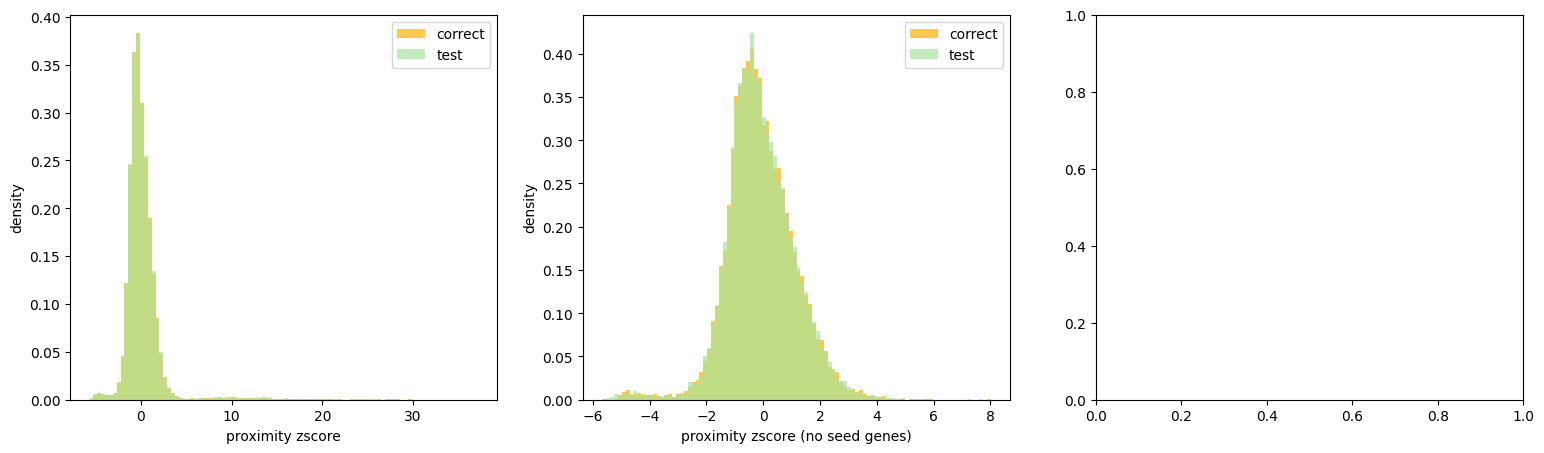

In [446]:
#import rare seed gene list and NPS scores
plt_histogram(tblr=NPS_c, tblc=NPS, 
              tblr_label='correct', tblc_label='test',
              tblr_seed=seed_genes, tblc_seed=seed_genes, 
              colour_r=colour_dict['loco'],colour_c=colour_dict['addict-rf'],colour_shared=colour_dict['shared_alt_addict-rf'],
              tblr_lim=0,
              tblc_lim=0,
              comb_lim=0,
              savefig=False,
             filename='')

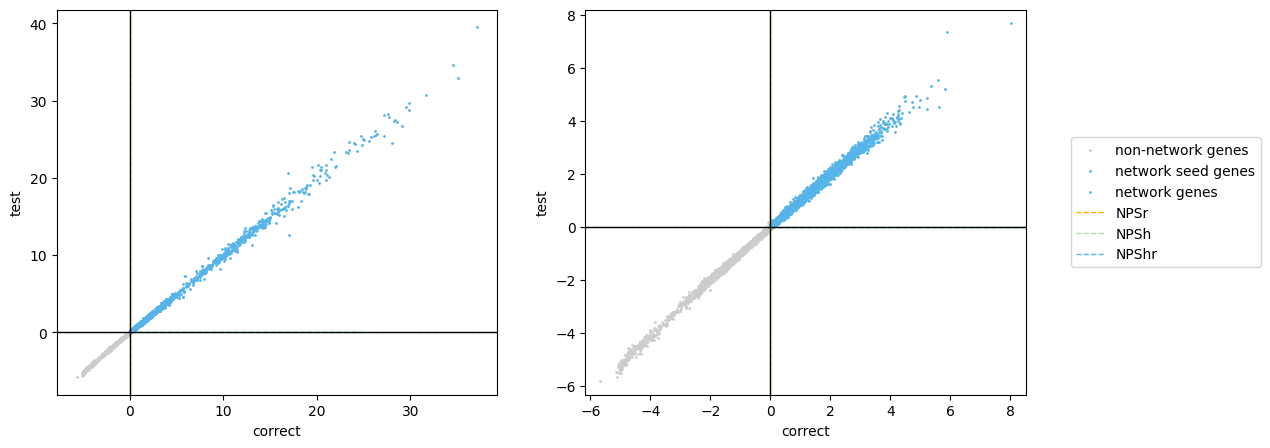

In [445]:
#import rare seed gene list and NPS scores
plt_scatter_NPS(tblr=NPS_c, tblc=NPS, 
              tblr_label='correct', tblc_label='test',
              tblr_seed=seed_genes, tblc_seed=seed_genes,
              colour_r=colour_dict['loco'],colour_c=colour_dict['addict-rf'],colour_shared=colour_dict['shared_alt_addict-rf'],colour_nonseed=colour_dict['shared_alt_addict-rf'],
              tblr_lim=0,
              tblc_lim=0,
              comb_lim=0,
              savefig=False,
             filename='')
